In [176]:
# %pip install PyMySQL
# %pip install pandas
# %pip install cryptography
# %pip install torch torchvision torchaudio

# 터미널에서 mysql에 사용자 추가하는 법
# mysql> CREATE user '사용자'@'localhost' IDENTIFIED BY '사용자_비밀번호';
# mysql> GRANT ALL PRIVILEGES ON *.* to '사용자'@'localhost'; # 모든 DB에 접근 가능 *.*
# mysql> FLUSH PRIVILEGES; # 새로운 세팅 적용
# 참고:http://bigdata.dongguk.ac.kr/lectures/DB/_book/python%EC%97%90%EC%84%9C-mysql%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%9D%98-%EC%A0%91%EA%B7%BC.html

import pymysql
import pandas as pd
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [177]:
con = pymysql.connect(host='localhost', user= 'kevinmj12', password='kookbop', db='1117kookbop', charset='utf8') # mysql connection 연결
cur = con.cursor() # connection으로부터 cursor 생성

sql = "SELECT user.user_num, review.review_user_id, review.review_menu_id_reviewd, review.menu_name, review.star, review.review_like FROM review INNER JOIN user ON review.review_user_id = user.nickname" 
# sql = "SELECT * FROM review"
cur.execute(sql) # sql문 실행

rows = cur.fetchall()
data = pd.DataFrame(rows)
testData = pd.DataFrame(rows)
data

,0,1,2,3,4,5
0,2,jihun,9,qq,2.5,0
1,2,jihun,10,rr,3.5,0
2,2,jihun,11,참치마요덮밥,3.5,0
3,2,jihun,12,mac,3.0,0
4,2,jihun,13,아이폰,2.5,0
5,2,jihun,14,쇠고기무국,2.5,0
6,2,jihun,14,쇠고기무국,2.5,0
7,2,jihun,14,쇠고기무국,1.5,0
8,2,jihun,15,삼계떡국,3.0,0
9,2,jihun,16,오믈렛라이스,4.5,0


In [178]:
menus = torch.LongTensor(data[2])
users = torch.LongTensor(data[0])
ratings = torch.FloatTensor(data[4])
menusTest = torch.LongTensor(testData[2])
usersTest = torch.LongTensor(testData[0])
ratingsTest = torch.FloatTensor(testData[4])
users

tensor([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
        3])

In [179]:
rank = 10 # Latent Vector의 개수
numMenus = menus.max()+1 # index 해결을 위해 +1 처리, 실제 결과값의 0행 0열은 더미값이다.
numUsers = users.max()+1
mean = ratings.mean()

tensor(12.5687)
tensor(12.9642)
tensor(12.5686)


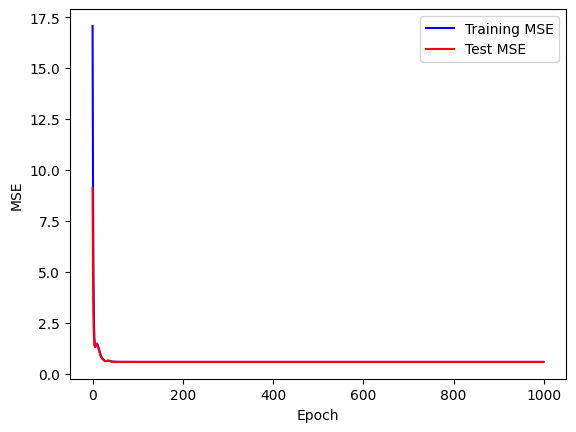

In [180]:
lambda1 = 0.5
lambda2 = 0.5
lambda3 = 0.5
lambda4 = 0.5
isOptimumLambda = False # 최적의 Lambda값을 찾기 위한 부울

X = []
Y = []
Y_test = [] # overfitting이 발생하는지 확인하기 위해 리스트에 값들 저장 후, pyplot을 통해 확인
prevDifference = 100
presentDifference = 0


while True:
  P = torch.randn(numMenus, rank, requires_grad=True) # menu Latent Factor 설정
  Q = torch.randn(numUsers, rank, requires_grad=True) # user Latent Factor 설정
  biasMenu = torch.randn(numMenus, requires_grad=True) # 정규화를 위한 menu Vector
  biasUser = torch.randn(numUsers, requires_grad = True) # 정규화를 위한 user Vecotor 
  optim = torch.optim.Adam([P, Q, biasMenu, biasUser], lr = 0.1) # optim.Adam()을 사용하여 머신러닝 시작
  X.clear()
  Y.clear()
  Y_test.clear()

  for epoch in range(1000):
    h = (P[menus] *Q[users]).sum(dim=1) + mean + biasMenu[menus] + biasUser[users] # 가설
    cost = F.mse_loss(h, ratings) # 비용
    loss = cost + lambda1*(P**2).mean() + lambda2*(Q**2).mean() + lambda3*(biasUser**2).mean() + lambda4*(biasMenu**2).mean() # 정규화

    optim.zero_grad()
    loss.backward()
    optim.step()

    X.append(epoch)
    Y.append(cost.item())
    with torch.no_grad():
      h_test = (P[menusTest] * Q[usersTest]).sum(dim=1) + mean + biasMenu[menusTest] + biasUser[usersTest]
      cost_test = F.mse_loss(h_test, ratingsTest)
      Y_test.append(cost_test.item())
    
    # with torch.no_grad():
      # if epoch % 100 == 0:
        # print(f"epoch: {epoch}, cost: {cost.item()}, cost_test: {cost_test.item()}\n h:{h}") # 비용과 가설의 학습 과정 확인 가능
        
  with torch.no_grad():
    presentDifference = (abs(h - ratings)).sum() # 실제 rating과 학습 이후 나온 rating을 비교하여 그 차이를 저장 (작을수록 정확하다)
    print(presentDifference)
    if isOptimumLambda: # 최적의 Lambda값을 찾았으므로 break
      break
    if prevDifference - presentDifference > 0: # 현재 학습이 이전 학습보다 잘 됨. Lambda값을 증가하며 계속 학습 진행
      lambda1 += 0.5
      lambda2 += 0.5
      lambda3 += 0.25
      lambda4 += 0.25
      prevDifference = presentDifference 
    else: # 현재 학습이 이전 학습보다 못 됨. 이전 학습했을 때의 Lambda값을 최적의 Lambda로 설정.
      lambda1 -= 0.5
      lambda2 -= 0.5
      lambda3 -= 0.25
      lambda4 -= 0.25
      isOptimumLambda = True

plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.plot(X, Y, c="blue", label = "Training MSE")
plt.plot(X, Y_test, c="red", label = "Test MSE")
plt.legend()
plt.show()

In [190]:
resultMatrix = torch.transpose(torch.mm(P, torch.transpose(Q,0,1))[1:],0,1)+mean+biasMenu[1:]
resultMatrix = resultMatrix[1:] + biasUser.unsqueeze(1)[1:]
# print(torch.transpose(torch.mm(P, torch.transpose(Q,0,1)),0,1)+mean+biasMenu+biasUser.unsqueeze(1))
print(resultMatrix) # 0행 0열 제거 버전

originalMatrix = torch.transpose(torch.mm(P, torch.transpose(Q,0,1)),0,1)+mean+biasMenu+biasUser.unsqueeze(1)
print(originalMatrix) # 오리지날 버전


todaysMenu = [9,10,11,12,13]
#print(originalMatrix[usernumber][todaysMenu])
userMenuRecommend = torch.sort(originalMatrix[2][todaysMenu], descending=True)
print(userMenuRecommend)
data


tensor([[3.3227, 3.2020, 3.1000, 3.1000, 3.1000, 3.1000, 3.1000, 3.1000, 3.0552,
         3.1286, 3.1282, 3.0919, 3.0551, 3.0291, 3.0919, 3.1291, 3.0919, 3.1654,
         3.1477, 2.9409, 3.1419, 3.1653, 3.2021],
        [2.8059, 2.9710, 3.1107, 3.1107, 3.1107, 3.1107, 3.1107, 3.1107, 2.5234,
         3.4851, 3.4853, 3.0042, 2.5234, 2.1790, 3.0042, 3.4924, 3.0042, 3.9660,
         3.7376, 1.0276, 3.6594, 3.9660, 4.4468],
        [4.8840, 3.9469, 3.1541, 3.1541, 3.1541, 3.1541, 3.1541, 3.1541, 3.2154,
         3.1150, 3.1121, 3.1652, 3.2151, 3.2623, 3.1652, 3.1144, 3.1652, 3.0667,
         3.0857, 3.3707, 3.0975, 3.0650, 3.0173]], grad_fn=<AddBackward0>)
tensor([[3.1000, 3.3227, 3.2020, 3.1000, 3.1000, 3.1000, 3.1000, 3.1000, 3.1000,
         3.0552, 3.1286, 3.1282, 3.0919, 3.0551, 3.0291, 3.0919, 3.1291, 3.0919,
         3.1654, 3.1477, 2.9409, 3.1419, 3.1653, 3.2021],
        [3.1000, 3.3227, 3.2020, 3.1000, 3.1000, 3.1000, 3.1000, 3.1000, 3.1000,
         3.0552, 3.1286, 3.1282, 3.091

TypeError: sort() received an invalid combination of arguments - got (Tensor, reverse=bool), but expected one of:
 * (Tensor input, *, bool stable, int dim, bool descending, tuple of Tensors out)
 * (Tensor input, int dim, bool descending, *, tuple of Tensors out)
 * (Tensor input, *, bool stable, name dim, bool descending, tuple of Tensors out)
 * (Tensor input, name dim, bool descending, *, tuple of Tensors out)
